<a href="https://colab.research.google.com/github/nematatu/Colab-Python/blob/master/%E6%84%9F%E6%83%85%E3%81%AB%E3%82%88%E3%82%8B%E3%83%86%E3%82%AD%E3%82%B9%E3%83%88%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
#ファイルの作成、ディレクトリの移動とか、OS依存の機能をいじるのに使う
import os
#re(Regular Expressions)正規表現を扱うのに使う
#文字列パターンを検索、抽出、置換したり
import re
#ファイル、ディレクトリの操作をするのに使う
#osと何が違うんだ↓
#shutilはosを基に、高度なファイル、ディレクトリ操作ができるようになったものらしい
import shutil
#文字列の操作に使う
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
print(tf.__version__)

2.14.0


In [4]:
#IMDB(Internet Movie DataBase)という50000件の映画レビューから抽出した、データセットを使う
#トレーニング用とテスト用に25000件ずつある
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
#↑urlからファイルをダウンロードする
#tf.keras.utils.get_file()
#"aclImdb": 保存先のディレクトリ名
#url: urlの指定
#untar: 保存するファイルが.tarなら、解凍するかどうか
#cache_dir: ファイルのダウンロード先のディレクトリを指定
#cache_subdir: 保存先のサブディレクトリを指定。今回はなし
dataset=tf.keras.utils.get_file("aclImdb",url,untar=True,cache_dir='.',cache_subdir='')
dataset_dir=os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 12s 0us/step


In [5]:
print(os.listdir(os.path.dirname(dataset)))
os.listdir(dataset_dir)

['.config', 'aclImdb.tar.gz', 'aclImdb', 'sample_data']


['train', 'README', 'imdbEr.txt', 'test', 'imdb.vocab']

In [6]:
train_dir=os.path.join(dataset_dir,'train')
print(os.listdir(train_dir))

['neg', 'unsup', 'labeledBow.feat', 'urls_pos.txt', 'urls_unsup.txt', 'unsupBow.feat', 'pos', 'urls_neg.txt']


In [7]:
sample_file=os.path.join(train_dir,'pos/1189_9.txt')
#with: 安全にファイル操作ができるらしい
with open(sample_file) as f:
  print(f.read())

The Last Hunt is one of the few westerns ever made to deal with Buffalo hunting, both as a sport and business and as a method of winning the plains Indian wars. Before the white man set foot on the other side of the Mississippi, the plains used to have herds of American Bison as large as some of our largest cities. By the time of the period The Last Hunt is set in, the buffalo had been all but wiped out. The 20th century, due to the efforts of conservationists, saw a revival in population of the species, but not hardly like it once was.<br /><br />Robert Taylor and Stewart Granger are co-starring in a second film together and this one is far superior to All the Brothers Were Valiant. Here Stewart Granger is the good guy, a world weary buffalo hunter, who has to go back to a job he hates because of financial considerations.<br /><br />The partner he's chosen to throw in with is Robert Taylor. Forgetting Taylor for the moment, I doubt if there's ever been a meaner, nastier soul than Char

In [8]:
remove_dir=os.path.join(train_dir,'unsup')
#shutil.rmtree(remove_dir)

In [9]:
batch_size=32
seed=42

#元のディレクトリから、テキスト形式のトレーニング用データセットにする
raw_train_ds=tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    #内20%を検証用に使う
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 75000 files belonging to 3 classes.
Using 60000 files for training.


In [10]:
print(raw_train_ds.class_names)

['neg', 'pos', 'unsup']


In [11]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review",text_batch.numpy()[i])
    print("Label",label_batch.numpy()[i])

Review b'There is this father-son conversation in the climax of \'KALPURUSH\'. I quote the English DVD-subtitle version. Shumonto tells his father: "I may not have become someone, but when I see two people in love, I smile. And when I see someone eating alone, I cry." Ashvini, his father, replies wistfully: "I wish I could\'ve lived my life like you did." These 2 lines, perhaps, comprise the gist of this new film by Buddhadev Dasgupta - director of teeny-weeny gems like \'Tahader Katha\', \'Bagh Bahadur\', \'Uttara\' & \'Mondo Meyer Upakhyan\' - which took nearly 3 years to reach the cinemas in India.<br /><br />The film opens with a man called Ashvini following a younger man called Shumonto, who, we are told, is his son. It seems that the father is stalking - or haunting, rather - his son. As the film progresses and we meet Shumonto\'s ambitious wife, Supriya, and his mother, Koyel, who seems to be tied up with something in her past, we realise that the son is, indeed, haunted by his 

In [12]:
print("label 0 correspond to ",raw_train_ds.class_names[0])
print("label 1 correspond to ",raw_train_ds.class_names[1])

label 0 correspond to  neg
label 1 correspond to  pos


In [13]:
#検証用データセットを作成
raw_val_ds=tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 75000 files belonging to 3 classes.
Using 15000 files for validation.


In [14]:
#テスト用データセットを作成
raw_test_ds=tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [15]:
#<br />とかのHTMLタグを消す編
def custom_standardization(input_data):
  lower_case=tf.strings.lower(input_data)
  #lower_case: 入力された文字列を小文字にしたもの
  #の中から、<br />を検索して、空白に置き換える
  stripped_html=tf.strings.regex_replace(lower_case,'<br />',' ')
  #string.panctuationに句読点などが含まれていて、それを/などをつけてエスケープしている
  #エスケープするとは、/!とすることで!に意味を持たせないようにすること
  #なぜそうするかというと、正規表現内で!は意味があるらしく、めんどくさいことを回避するためにやってるらしい
  #そうして集めた奴らを、['%s']の%sに代入して空白に置換している
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),' ')

In [16]:
#データの前処理編
max_features=10000
sequence_length=250

#テキストデータを整数のベクトルに変換しているらしい
vectorize_layer=layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [17]:
#前処理実践編
#.map()でデータセットに関数を適応させる
#lambdaは無名関数で、xとyを引数にとってxを返す関数
#raw_train_dsは、(text,label)の形になっていて、textだけを抽出しているということ
train_text=raw_train_ds.map(lambda x,y:x)
#前処理として、レイヤーにトレーニングデータを元に学習させているだけ
#関数の引数的なvectorize_layer(train_text)とは違う
#↑はちゃんとテキストをベクトルに変換している
#↓は変換まではしない
vectorize_layer.adapt(train_text)

In [18]:
#前処理確認編
def vectorize_text(text,label):
  #textの要素の-1番目、すなわち最後に１つ次元を追加する
  #(batch_size,sequence_length)->(batch_size,sequence_length,1)となる
  #最初に追加したければ、ext=tf.expand_dims(text,0)
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [19]:
#next(iter())を使うことでいい感じにメモリを効率よく使えるらしい
#やってることは、全部取ってきてる
text_batch,label_batch=next(iter(raw_train_ds))
first_review,first_label=text_batch[0],label_batch[0]

print("Review",first_review)
print("Label",raw_train_ds.class_names[first_label])
print("Vectorized review",vectorize_text(first_review,first_label))

Review tf.Tensor(b"British man Brian Roberts (Michael York) comes to Berlin to teach English in the 1930's, at the time the Nazi party is rising.There he meets an interesting singer Sally Bowles (Liza Minnelli).The bi-sexual teacher becomes very fond of her.In between there's the handsome and rich Maximilian von Heune (Helmut Griem).In Berlin he also meets people as Fritz Wendel (Fritz Wepper) and (Natalia Landauer).They're both Jewish and attracted to each other.Joel Grey is the eccentric Master of Ceremonies.The cast is absolutely fantastic in this Bob Fosse's musical drama.I read about two years ago Christopher Isherwood's Goodbye to Berlin, which this movie is based on.This week I saw the movie and they're both great.In the movie you can hear the songs being sang and they're all marvelous.I truly recommend this movie to a whole bunch of people.", shape=(), dtype=string)
Label unsup
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 705,  127, 1736, 2816,  5

In [20]:
print("1287 --->",vectorize_layer.get_vocabulary()[1287])
print("313 --->",vectorize_layer.get_vocabulary()[313])
print('vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


1287 ---> trip
313 ---> wife
vocabulary size: 10000


In [21]:
#最後の前処理
train_ds=raw_train_ds.map(vectorize_text)
val_ds=raw_val_ds.map(vectorize_text)
test_ds=raw_test_ds.map(vectorize_text)

In [22]:
#AUTOTUNE: パフォーマンスを向上させるために自動で最適な値が選ばれる
AUTOTUNE=tf.data.AUTOTUNE

#cache()とすることで、データセットを一時的に保存することで以後高速化できる
#prefetch() :非同期に実行。トレーニングと、データの前処理などを非同期にいける
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
#モデルを作成
embedding_dim=16

In [24]:
model=tf.keras.Sequential([
    #layers.Embedding(): 自然言語処理系でよく使われる、文章を多次元ベクトルに変換するAPI
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    #GlobalAveragePooling1D: Embeddingによってベクトルに変換された文章のベクトルの次元ごとに平均を取る
    #これにより、文章の特徴をコンパクトにまとめることができる
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [25]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [26]:
epochs=10
history=model.fit(
    train_ds,
    #validataion_data: トレーニング後に検証用データセットを使って評価する
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: -15.3755 - binary_accuracy: 0.1663 - val_loss: -43.5949 - val_binary_accuracy: 0.1681
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: -96.3056 - binary_accuracy: 0.1663 - val_loss: -152.8668 - val_binary_accuracy: 0.1681
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: -234.6417 - binary_accuracy: 0.1663 - val_loss: -310.3115 - val_binary_accuracy: 0.1681
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: -417.9184 - binary_accuracy: 0.1663 - val_loss: -510.8307 - val_binary_accuracy: 0.1681
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: -645.2557 - binary_accuracy: 0.1663 - val_loss: -753.1915 - val_binary_accuracy: 0.1681
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: -917.5320 - binary_accuracy: 0.1663 - val_loss: -1036.9404 - val_binary_accuracy: 0.1681
Epoch 7/10


In [27]:
loss,accuracy=model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 2640.3953 - binary_accuracy: 0.5000
Loss:  2640.395263671875
Accuracy:  0.5


In [28]:
#history.histroy: model.fit()中に全ての情報
history_dict=history.history
#history.historyに含まれる項目を出してる
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

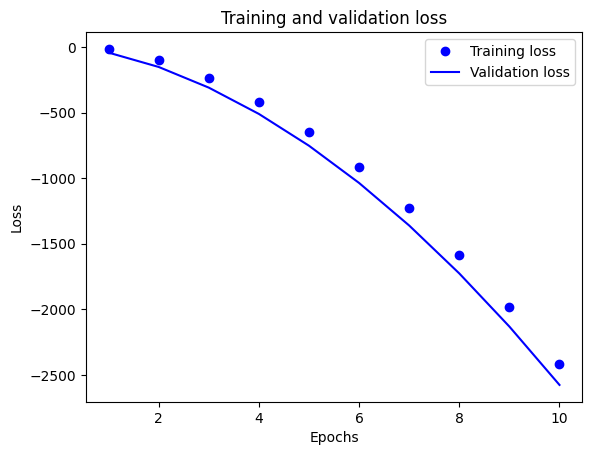

In [35]:
acc=history_dict['binary_accuracy']
val_acc=history_dict['val_binary_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

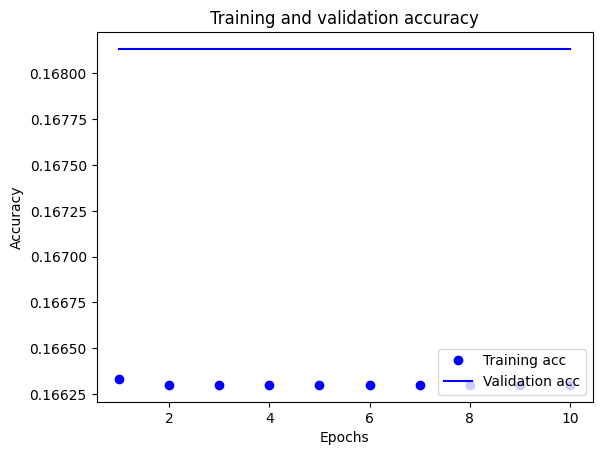

In [38]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
